In [3]:
import SNIDsn
import SNIDdataset as snid
import numpy as np
import SNePCA

import plotly.plotly as ply
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.pyplot as plt

import pandas
from BinSpectra import lowres_dataset
import warnings
from progress.bar import Bar
import random

#warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')
PATH = '../Data/DataProducts/'

In [9]:
def loaddata(phase):
    """
    Loads the pickled dataset
    """
    dsname = "dataset{}.pickle".format(phase)
    return snid.loadPickle(PATH + dsname)   


def get_bin_length(phase, bin_factor):
    dataset = loaddata(phase)
    dataset_key_list = list(dataset.keys())
    wvl = dataset[dataset_key_list[0]].wavelengths
    wbin = (np.log(wvl[1]) - np.log(wvl[0])) * bin_factor
    return wbin




def classify_plot_spectra(phase, dphase=5):
    """
    Plots the lower resolution spectra just before feeding to the classifier.
    Classifies the given spectra at lower resolutions.
    Parameters
    ----------
    phase : integer, phase of the dataset.
    
    Returns
    -------
    bin_length: array
    Average SVM scores: Dictionary, Average SVM scores for each principle component at each lower resolution.
    """
    warnings.filterwarnings('ignore')
    exclude = ['sn2007uy', 'sn2009er', 'sn2005ek']
    av_svm_score_dict = {}
    av_svm_std = {}
    bin_length_list = []
    bar = Bar('Processing', max=20)
    PATH_save = '../Plots/lowres/'
    m = 1
    bf_list = list(np.arange(1., 83., 9.))
    #print("starting loop")
    for bf in bf_list:
        bin_length = get_bin_length(phase, bf)
        dataset = loaddata(phase)
        dataset_lowres = lowres_dataset(dataset, bin_length)
        ###### this section plots the spectra at each lower resolution before feeding to the classifier ##########
#         dataset_key_list = list(dataset_lowres.keys())
#         plot_dataset, axs = plt.subplots(len(dataset_lowres), 1, figsize=(16,200))
#         number_of_colors = len(dataset)
#         colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#              for h in range(number_of_colors)]
#         i = 0
#         #print("SN plot loop")
#         #axs.set_prop_cycle(cycler('color', colors))
#         for sne in dataset_key_list:
#             wvl = dataset_lowres[sne].wavelengths
#             flux = dataset_lowres[sne].data
#             axs[i].plot(wvl, flux, color = colors[i], linewidth=1.5, label = "%s"%sne)
#             axs[i].set_ylabel('Flux', fontsize=18)
#             axs[-1].set_xlabel('Wavelength', fontsize=18)
#             axs[i].tick_params(axis='both', which='major', labelsize=18)
#             axs[i].legend(loc="upper right", fontsize = '12')
#             axs[0].set_title('%d. Spectra at bin length: %2f (Bin factor: %d)' %(m, bin_length, bf), fontsize=18)
#             #plot_dataset.tight_layout()
#             i = i + 1
        #    print(i)
        #print(m, np.round(bin_length, 2))
        m = m + 1
        #plot_dataset.savefig(PATH_save + 'spectra_plot_ph%d_%d.png'%(phase, m), bbox_inches='tight')
        #plt.close()
        #####################################################################################################
        snidPCA_ph = SNePCA.SNePCA(dataset_lowres, phase - dphase, phase + dphase)
        snidPCA_ph.snidPCA()
        snidPCA_ph.calcPCACoeffs()
        for i in range(1, 2): #range(1,6)
            for j in range(5, 6): #range(1,6)
                svmsc,av,std=snidPCA_ph.runSVM(i,j,(10,7),alphamean=.5,alphaell=.1,alphasvm=10,purity=True,
                                               excludeSNe=exclude,std_rad=1.0,svm=True,count=3,
                                               fig=None,ax=None,ncv=3,markOutliers=True)
                av_svm_score_dict.setdefault('PC%d vs PC%d'%(i, j), []).append(av)
                av_svm_std.setdefault('PC%d vs PC%d'%(i, j), []).append(std)
        bin_length_list.append(bin_length)
        bar.next()
        plt.show()
    bar.finish()
    return np.array(bin_length_list), av_svm_score_dict, av_svm_std

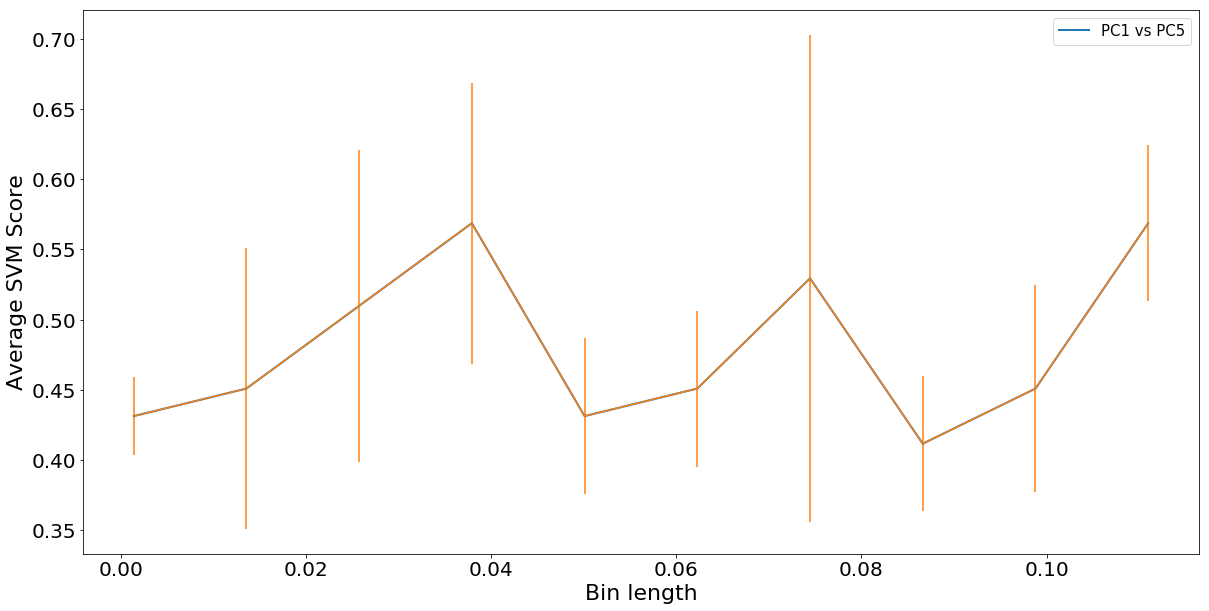

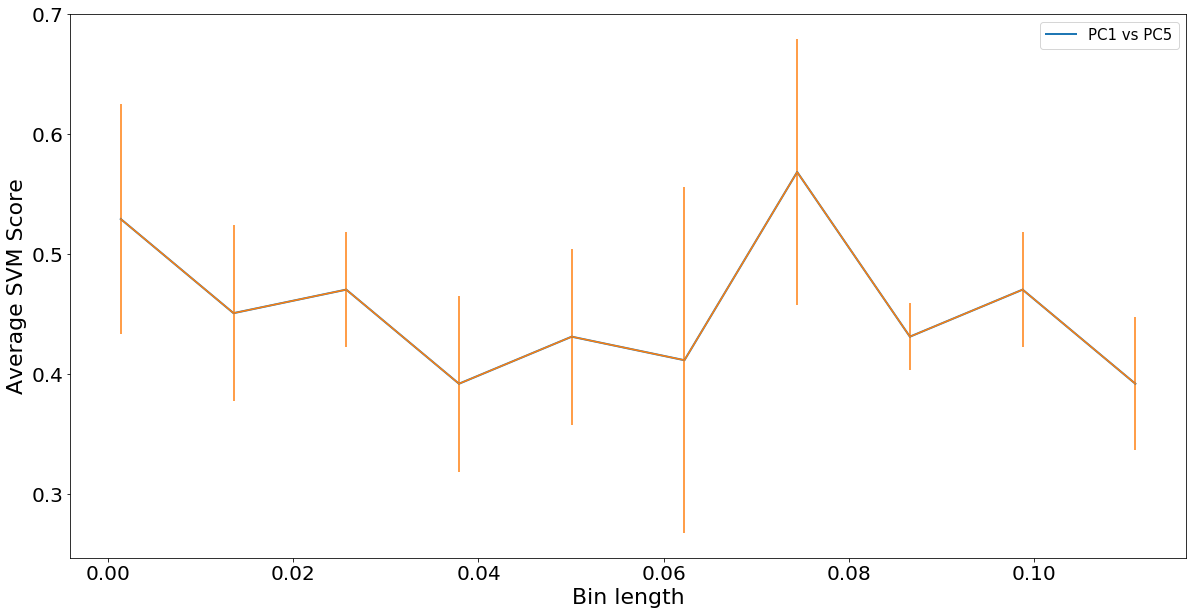

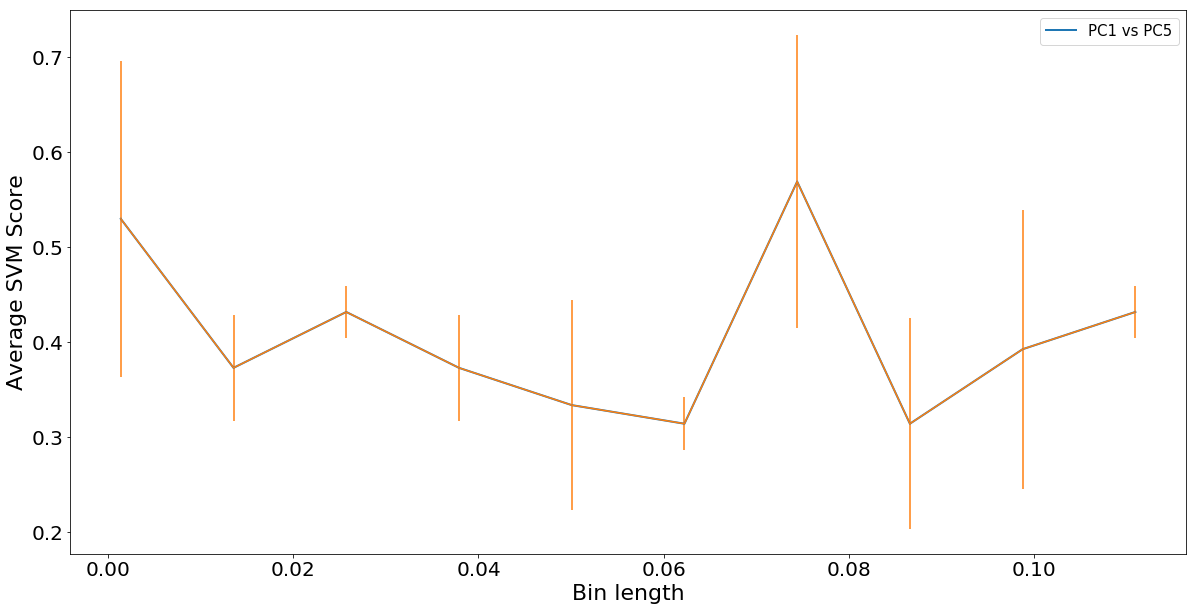

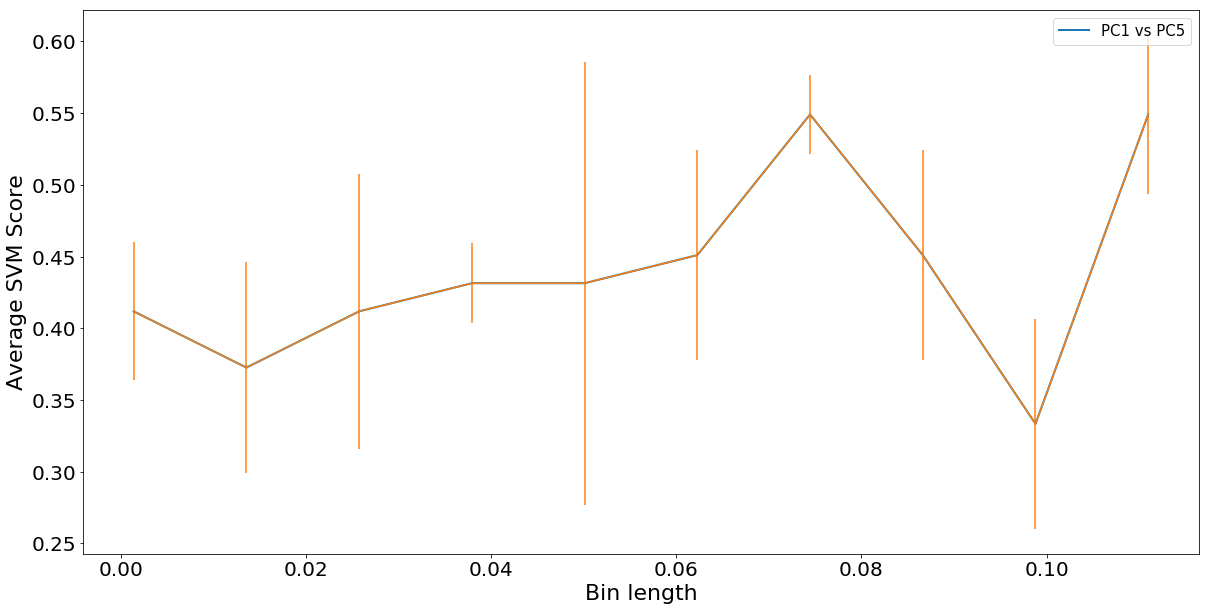

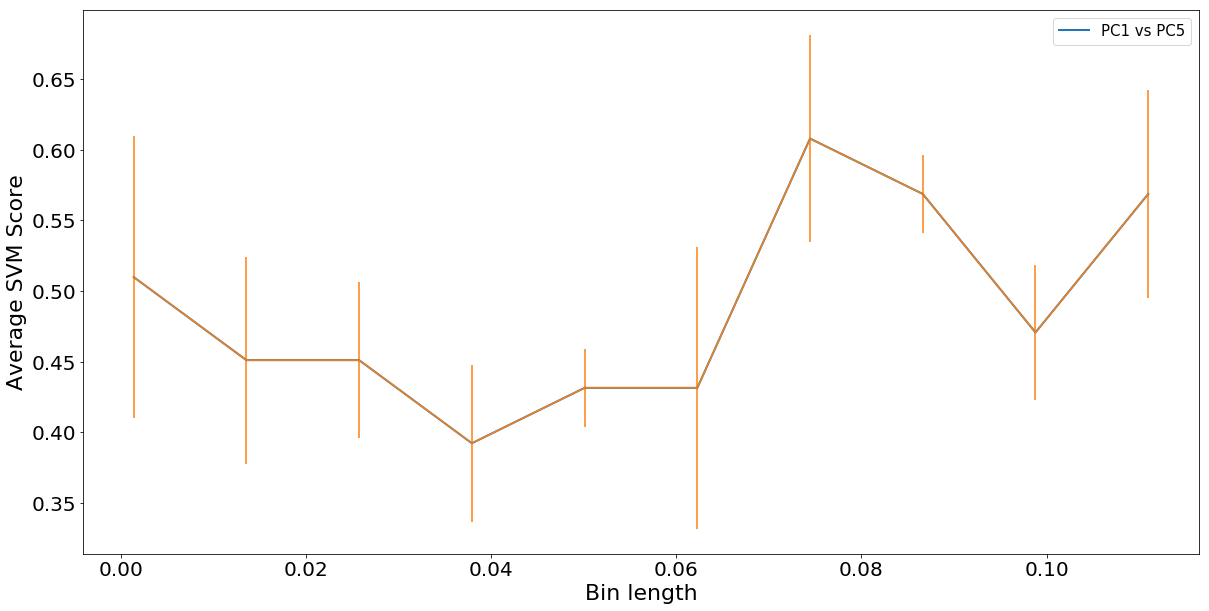

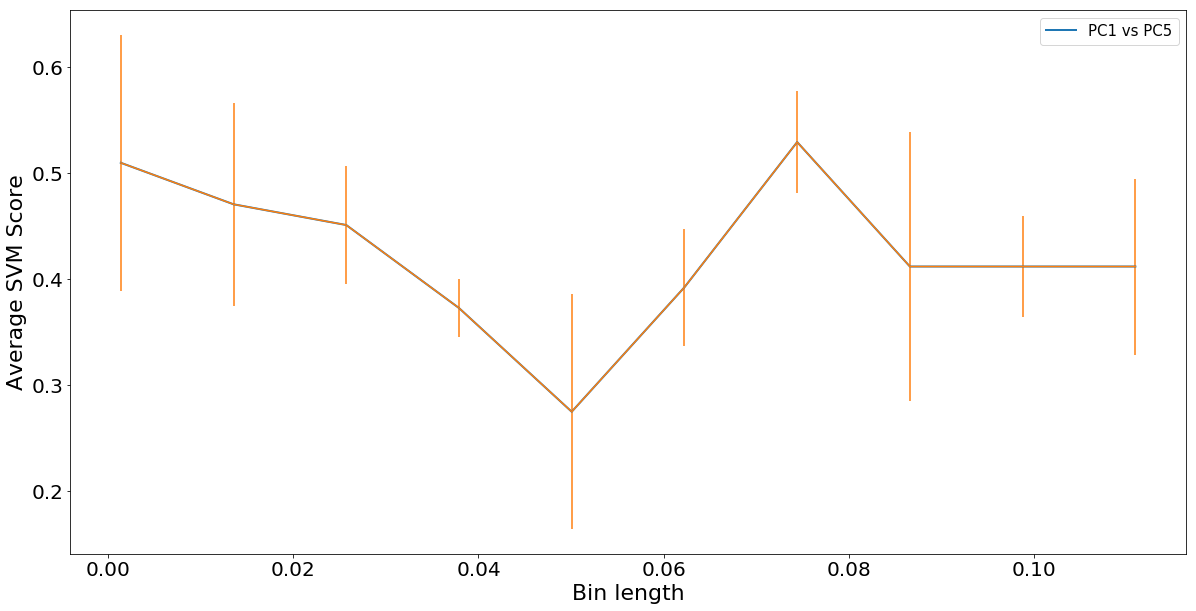

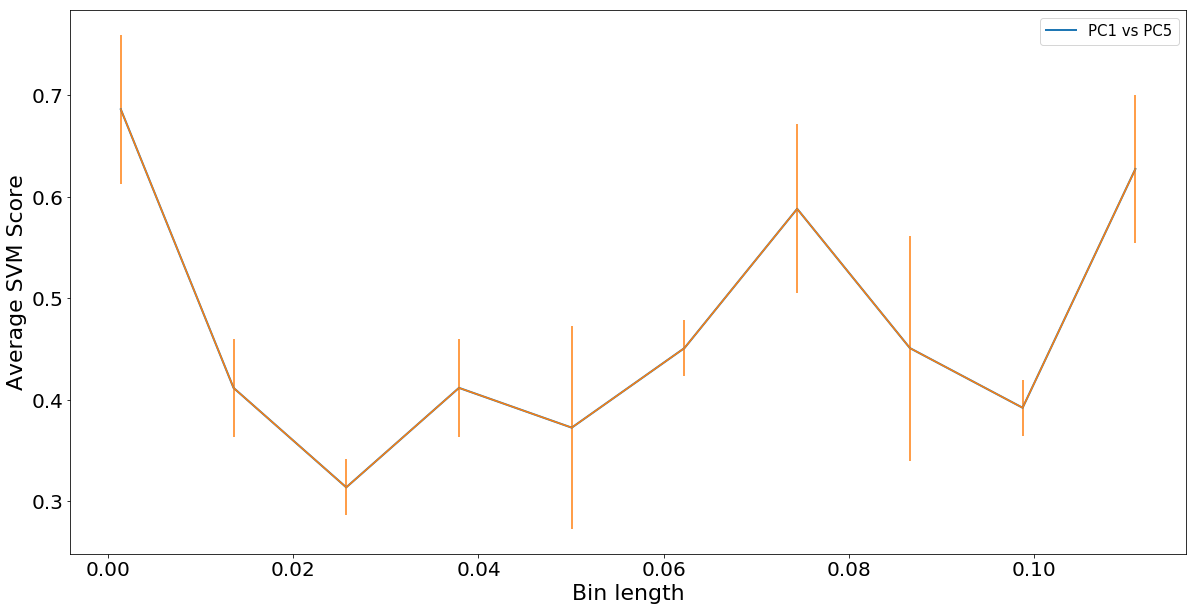

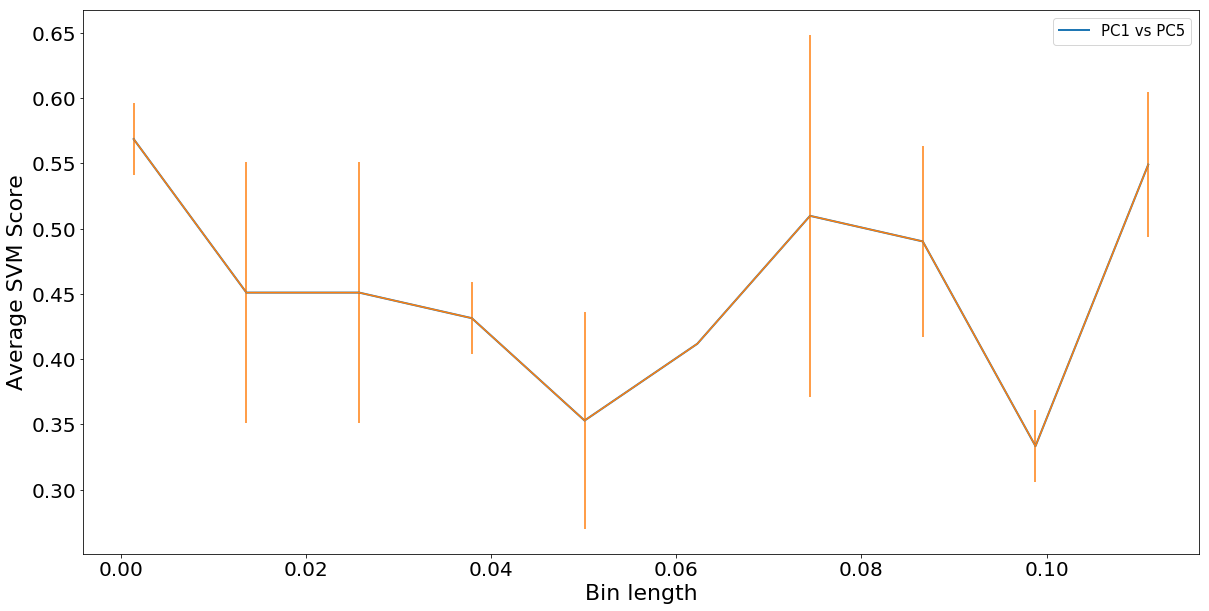

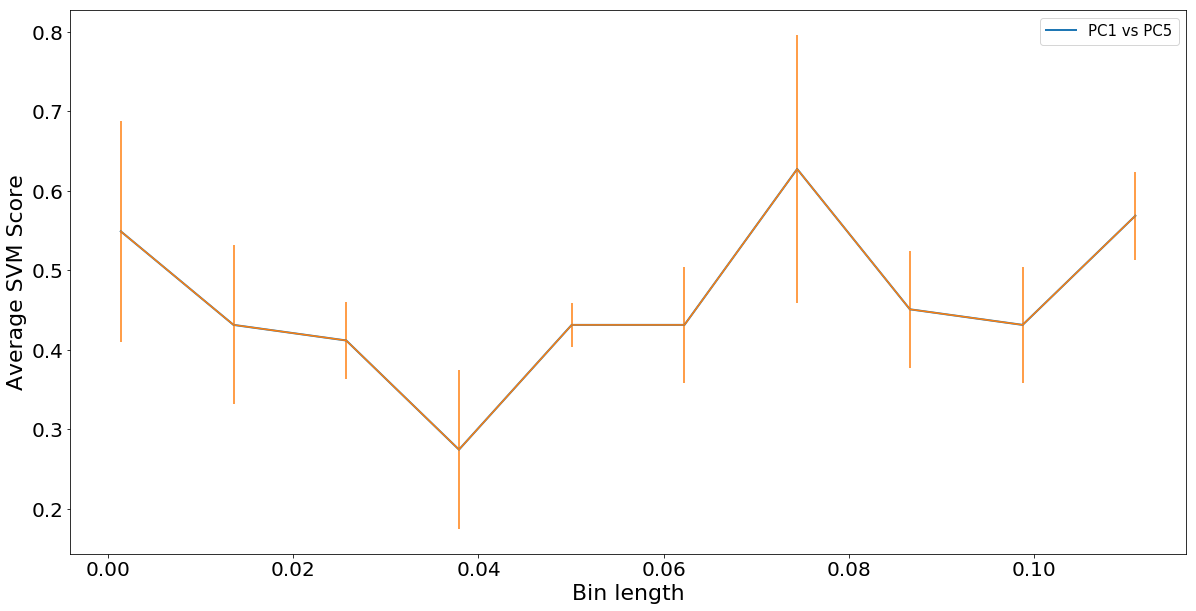

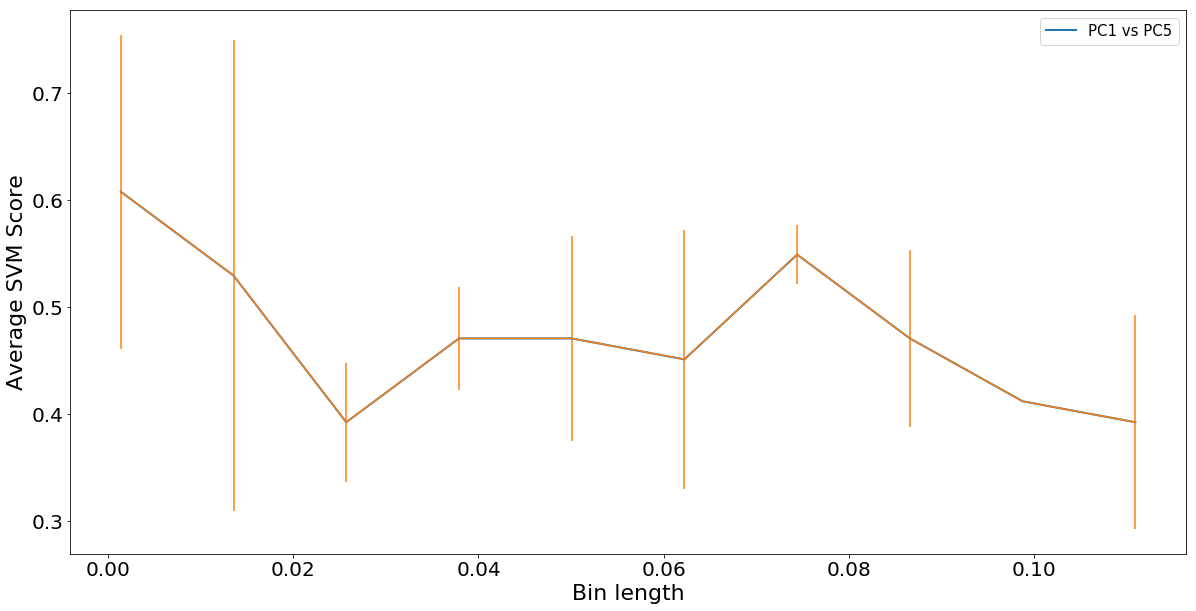

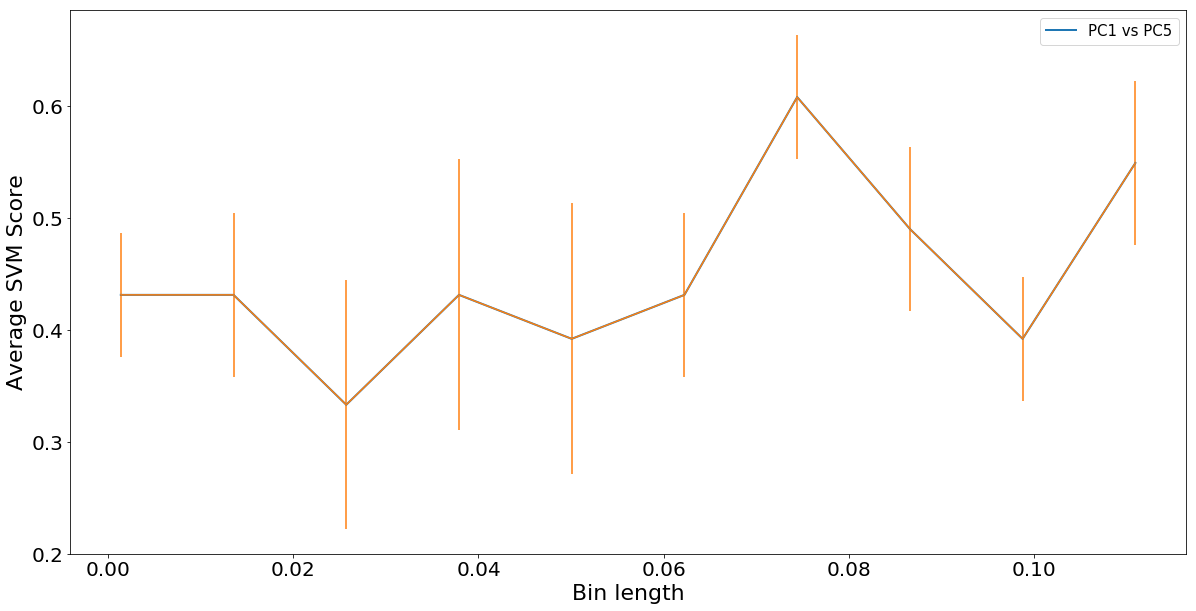

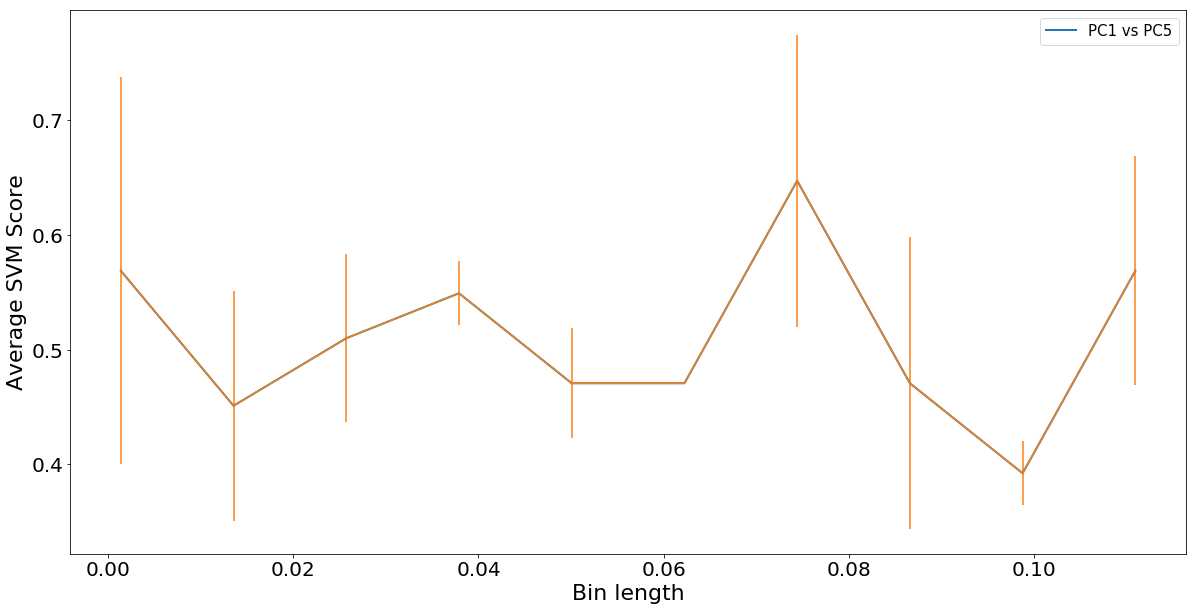

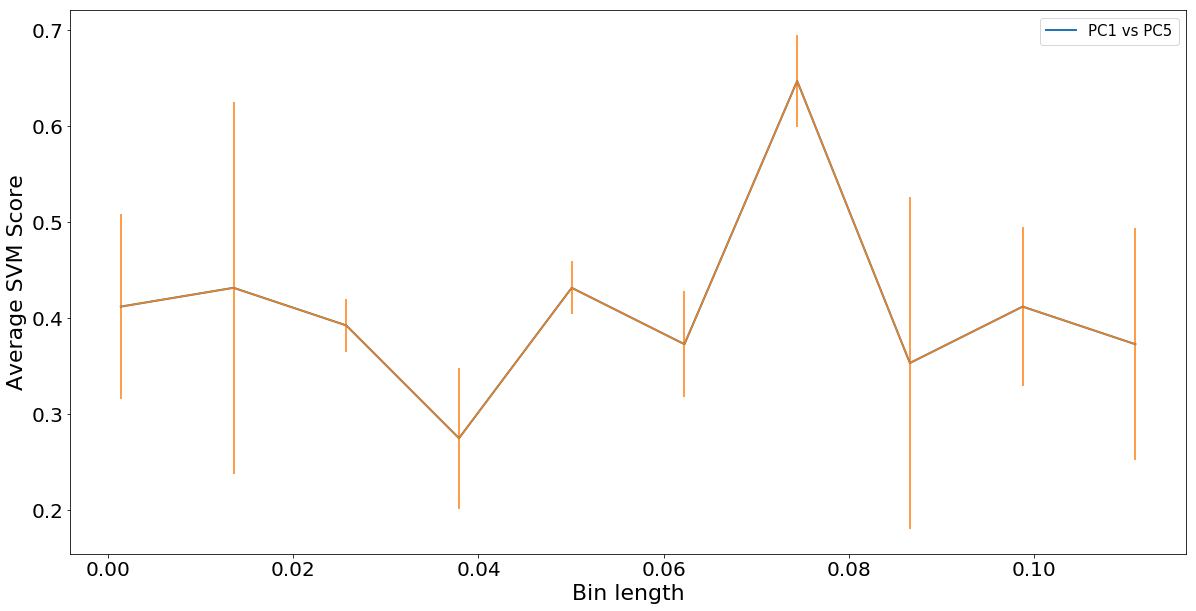

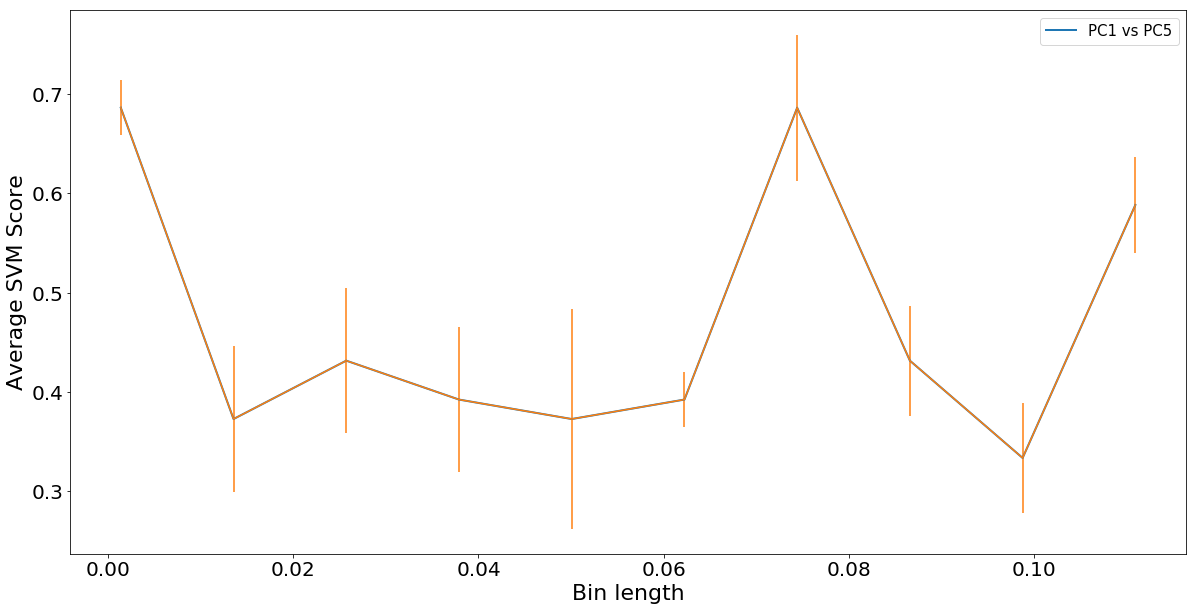

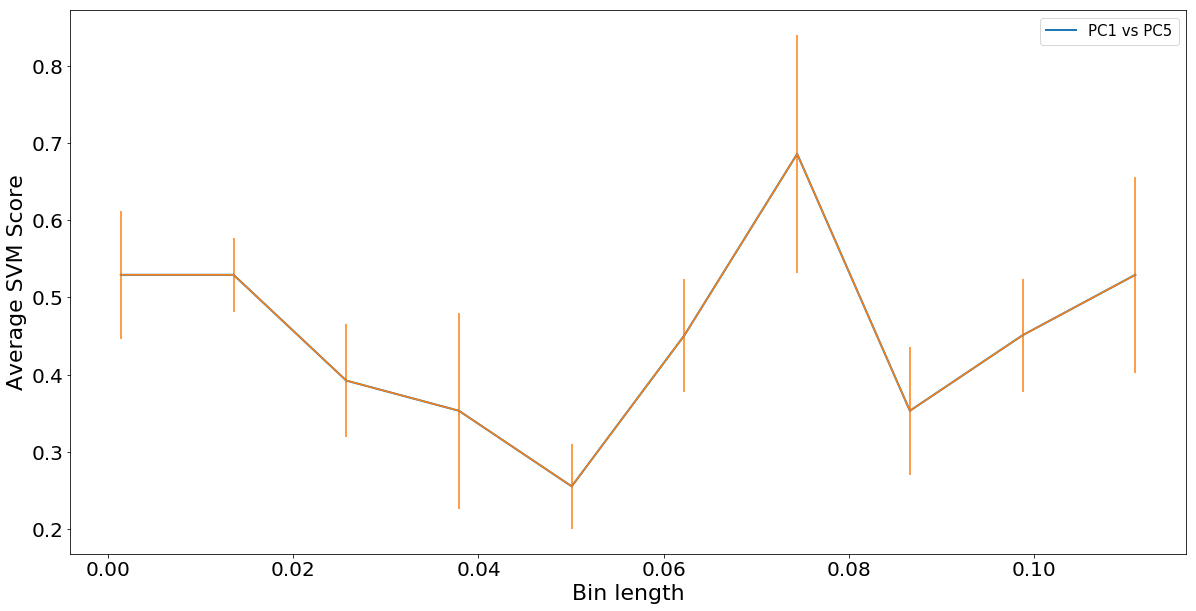

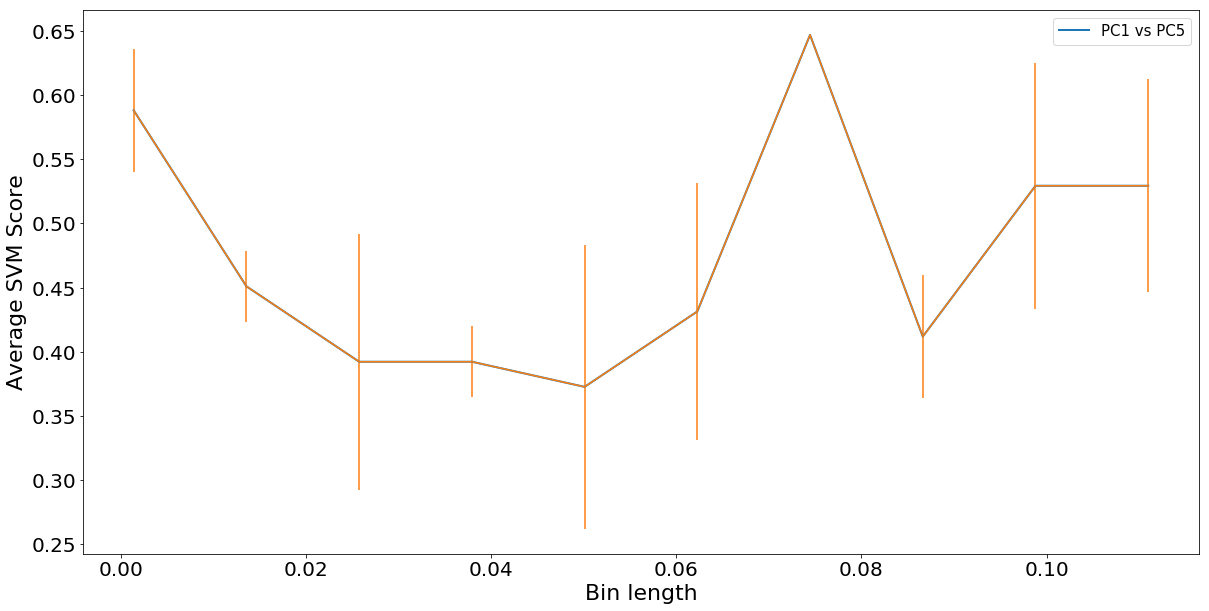

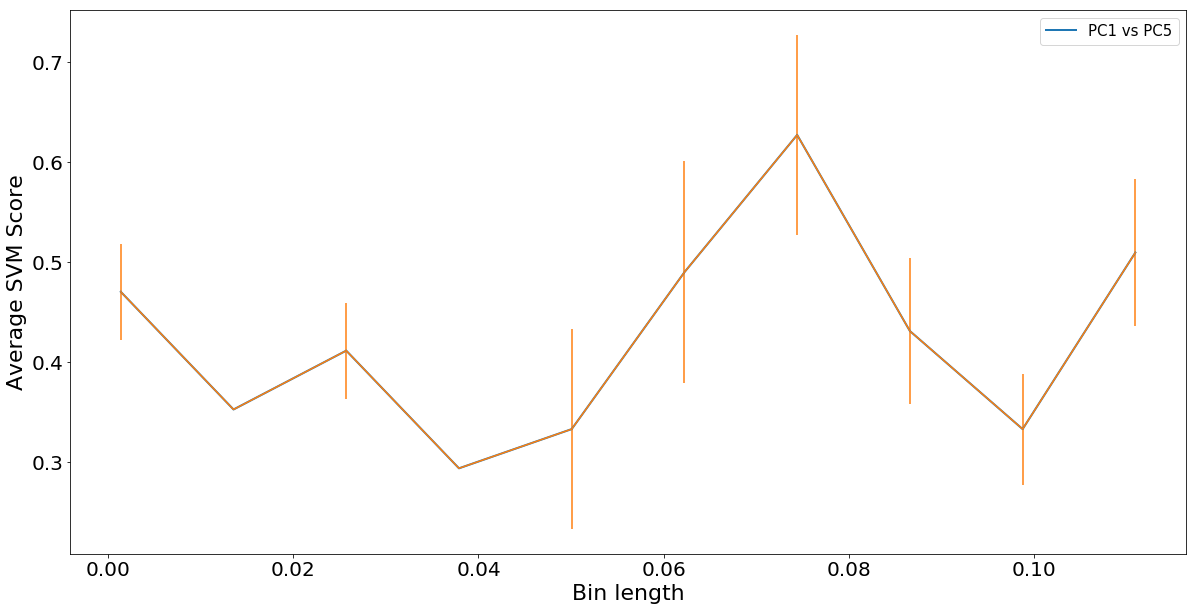

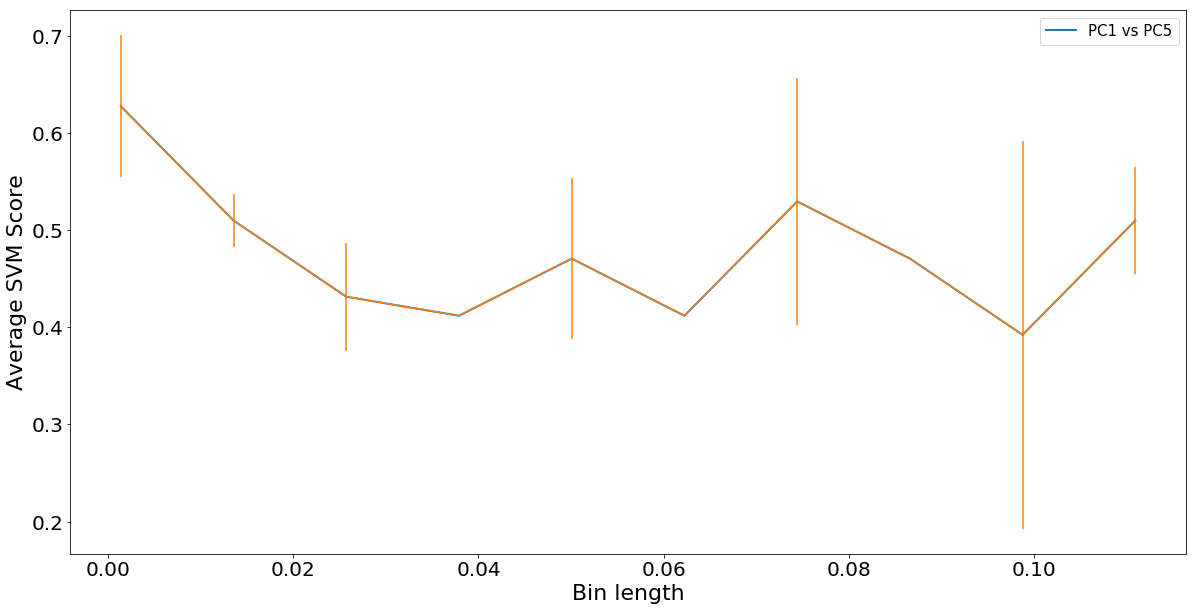

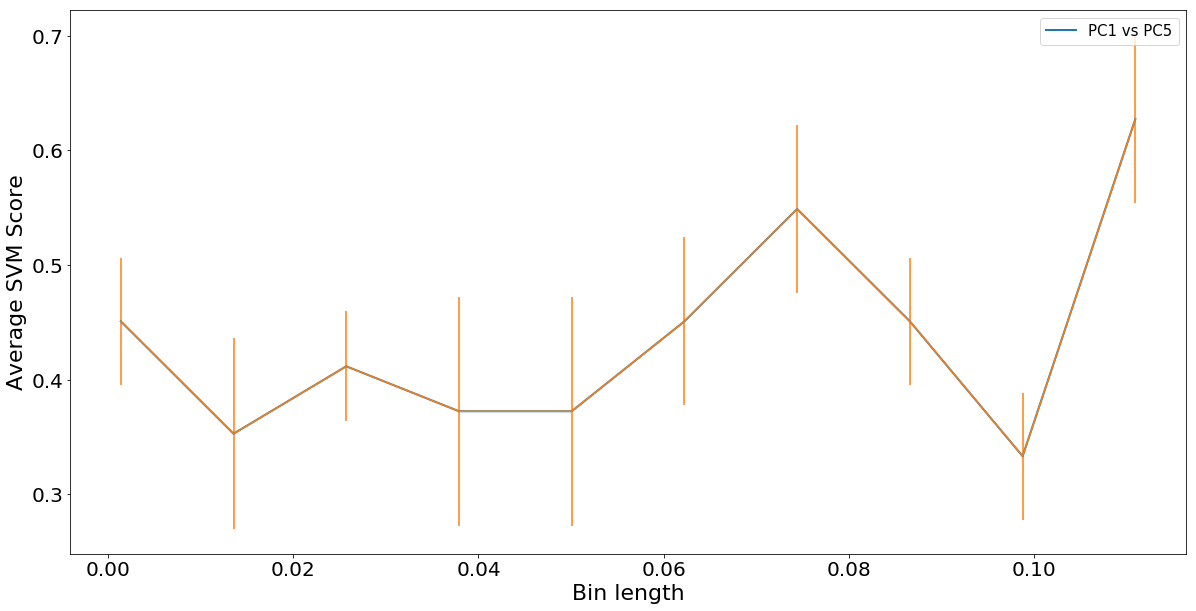

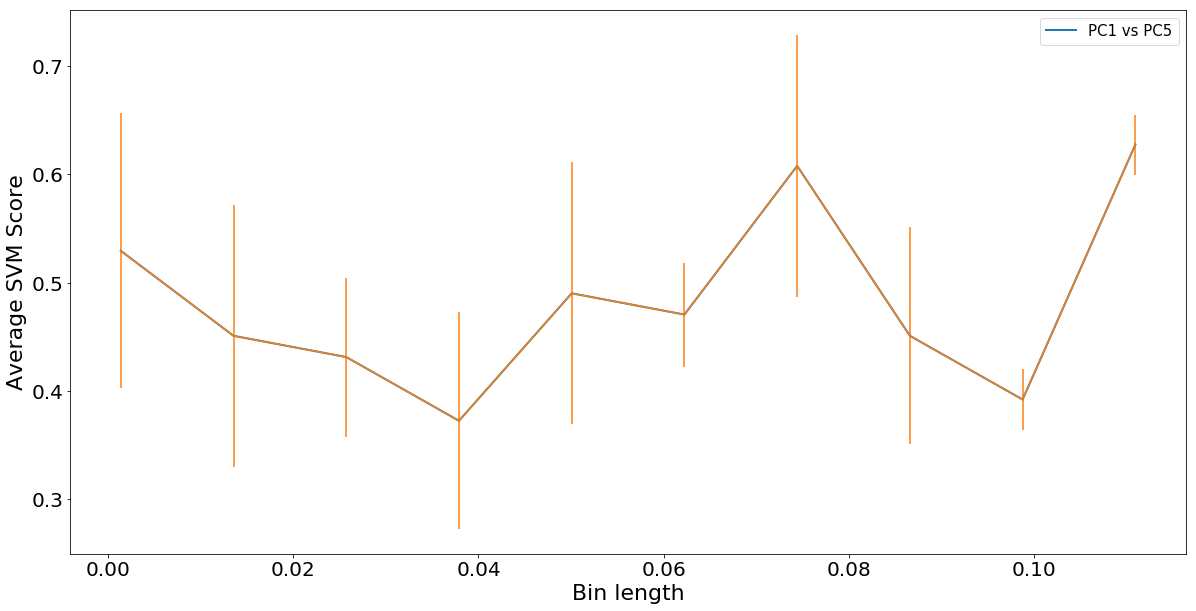

In [11]:
for k in range(20):
    svm_score = classify_plot_spectra(0)
    plt.figure(figsize=(20,10))
    for i in range(1, 2):
        for j in range(5, 6):
            pcstring = "PC{} vs PC{}".format(i, j)
            #print(pcstring)

            plt.plot(svm_score[0], svm_score[1][pcstring], label =pcstring, linewidth=2)
            plt.errorbar(svm_score[0], svm_score[1][pcstring], yerr = svm_score[2][pcstring])
    plt.xlabel('Bin length', fontsize=22)
    plt.ylabel('Average SVM Score', fontsize=22)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=15)

In [12]:
avg_svm_scores = svm_score[1]['PC1 vs PC5']
uncertainties = svm_score[2]['PC1 vs PC5']

In [13]:
avg_svm_scores, uncertainties

([0.5294117647058824,
  0.45098039215686275,
  0.4313725490196078,
  0.37254901960784315,
  0.4901960784313726,
  0.4705882352941176,
  0.6078431372549019,
  0.45098039215686275,
  0.392156862745098,
  0.6274509803921569],
 [0.12707334702760512,
  0.12087086280331326,
  0.07336583111321453,
  0.09998077477632912,
  0.12087086280331329,
  0.04802921064280742,
  0.12087086280331323,
  0.09998077477632912,
  0.02772967769359008,
  0.027729677693590107])